In [1]:
!pip install llama-index-experimental

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -r azure-search-vector-python-llamaindex-sample-requirements.txt --quiet


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# !pip install html5lib lxml

In [4]:
import logging
import sys
# from IPython.display import Markdown, display

import pandas as pd
from llama_index.experimental.query_engine import PandasQueryEngine


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

In [6]:
load_dotenv(override=True) # take environment variables from .env.

# Make sure your .env file has values for the following environment variables
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
# index_name = os.environ["AZURE_SEARCH_INDEX"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
# Llama Index does not support RBAC authentication, an API key is required
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
if len(azure_openai_key) == 0:
    raise Exception("API key required")
azure_openai_embedding_model = os.environ["AZURE_OPENAI_EMBEDDING_MODEL"]
azure_openai_embedding_deployment = os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"]
azure_openai_chatgpt_deployment = os.environ["AZURE_OPENAI_CHATGPT_DEPLOYMENT"]
azure_openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"]
# embedding_dimensions = int(os.getenv("AZURE_OPENAI_EMBEDDING_DIMENSIONS", 1536))

In [7]:
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
embeddings = AzureOpenAIEmbedding(
    model_name=azure_openai_embedding_model,
    deployment_name=azure_openai_embedding_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_key
)

In [8]:
from llama_index.llms.azure_openai import AzureOpenAI
llm = AzureOpenAI(
    deployment_name=azure_openai_chatgpt_deployment,
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_key
)

In [9]:
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.core.settings import Settings

Settings.llm = llm

In [25]:
from llama_index.readers.web import SimpleWebPageReader

# Define the target URL
url1 = "https://chat-test-blog.blogspot.com/2024/07/primeministerofindia.html"
url2 = "https://chat-test-blog.blogspot.com/2024/07/presidentofusa.html"
url3 = "https://jainsocietyhouston.app.neoncrm.com/np/clients/jainsocietyhouston/neonPage.jsp?pageId=1"
url4 = "https://www.jainsocietyhouston.org/about_us"

web_documents = SimpleWebPageReader().load_data(
    [url1, url2, url3, url4]
)

# Extract the content from the website data document
html0_content = web_documents[0].text
print(html0_content)

# Extract the content from the website data document
html1_content = web_documents[1].text
print(html1_content)

# Extract the content from the website data document
html2_content = web_documents[2].text
print(html2_content)

# Extract the content from the website data document
html3_content = web_documents[3].text
print(html3_content)

html_content = html0_content + html1_content + html2_content + html3_content

<!DOCTYPE html>
<html dir='ltr' lang='en'>
<head>
<meta content='width=device-width, initial-scale=1' name='viewport'/>
<title>PrimeMinisterofIndia</title>
<meta content='text/html; charset=UTF-8' http-equiv='Content-Type'/>
<!-- Chrome, Firefox OS and Opera -->
<meta content='#eeeeee' name='theme-color'/>
<!-- Windows Phone -->
<meta content='#eeeeee' name='msapplication-navbutton-color'/>
<meta content='blogger' name='generator'/>
<link href='https://chat-test-blog.blogspot.com/favicon.ico' rel='icon' type='image/x-icon'/>
<link href='https://chat-test-blog.blogspot.com/2024/07/primeministerofindia.html' rel='canonical'/>
<link rel="alternate" type="application/atom+xml" title="ChatTestBlog - Atom" href="https://chat-test-blog.blogspot.com/feeds/posts/default" />
<link rel="alternate" type="application/rss+xml" title="ChatTestBlog - RSS" href="https://chat-test-blog.blogspot.com/feeds/posts/default?alt=rss" />
<link rel="service.post" type="application/atom+xml" title="ChatTestBlog -

In [27]:
from bs4 import BeautifulSoup
from llama_index.core import Document
# Parse the data.
soup = BeautifulSoup(html_content, 'html.parser')
p_tags = soup.findAll('p')
text_content = ""
for each in p_tags:
    text_content += each.text + "\n"

# Convert back to Document format
documents = [Document(text=text_content)]
print(documents)

[Document(id_='895f64db-e1ec-4d61-95ef-47efb98200f3', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='\n\nPrime Minister of India in 2024 is Narendra Modi.\nPrime Minister of India in 1947 was Jawaharlal Nehru.Prime Minister of India in 1996 was Devegowda.\n\n\nPresident of USA in 2024 is Joe Biden.President of USA in 2004 was George W. Bush\nGood news is that if you are a JSH member, your account, membership and household are already setup.\nTo access your account go to www.jainsocietyhouston.org\xa0-> JSH Connect Login -> Reset Password (use same email that you get emails from JSH)\nIf you dont get reset password email from JSH Connect within 10 minutes, please check spam\xa0folder in your email account.\xa0\n\xa0\nPlease read thru below information and if issue still persists then use the "Open a New Ticket" link. JSH Connect Team generally turns issues around in 1-3 business days.\xa0\n\xa0\nWatch this JSH Connect

In [28]:
from azure.search.documents.indexes import SearchIndexClient

# Index name to use
index_name = "llamaindex-vector-test-blog-jsh-demo"

# Use index client to demonstrate creating an index
index_client = SearchIndexClient(
    endpoint=endpoint,
    credential=credential,
)

In [29]:
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore
from llama_index.vector_stores.azureaisearch import (
    IndexManagement,
    MetadataIndexFieldType,
)

metadata_fields = {

}

vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    filterable_metadata_field_keys=metadata_fields,
    index_name=index_name,
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="chunk",
    embedding_field_key="embedding",
    embedding_dimensionality=1536,
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn")

INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=minimal'
    'x-ms-client-request-id': '171fd534-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python/3.10.14 (Linux-5.15.0-1064-azure-x86_64-with-glibc2.36)'
No body was attached to the request
Request URL: 'https://genai-cognitive-search.search.windows.net/indexes?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=minimal'
    'x-ms-client-request-id': '171fd534-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python/3.10.14 (Linux-5.15.0-1064-azure-x86_64-with-glibc2.36)'
No body was attached to the request
INFO:azure.core.pipeline.policies.http_logging_policy:Response

In [30]:
from llama_index.core import (
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.core.settings import Settings

storage_context = StorageContext.from_defaults(vector_store=vector_store)

Settings.llm = llm
Settings.embed_model = embeddings
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"


INFO:llama_index.vector_stores.azureaisearch.base:Uploading remaining batch of size 2, current progress 2 of 2
Uploading remaining batch of size 2, current progress 2 of 2
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.index?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '77250'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '1c99d370-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python/3.10.14 (Linux-5.15.0-1064-azure-x86_64-with-glibc2.36)'
A body is sent with the request
Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.index?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type':

In [31]:
blog_query_engine = index.as_query_engine()
response = blog_query_engine.query("Who is Prime Minister of India in 2024?")
print(response)
response = blog_query_engine.query("Who is Prime Minister of India in 1996?")
print(response)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.vector_stores.azureaisearch.base:Vector search with supplied embedding
Vector search with supplied embedding
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '34546'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '20b0d7e2-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
Narendra Modi is the Prime Minister of India in 2024.
INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.vector_stores.azureaisearch.base:Vector search with supplied embedding
Vector search with supplied embedding
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-tes

In [32]:
blog_query_engine = index.as_query_engine()
response = blog_query_engine.query("Who is president of united states??")
print(response)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.vector_stores.azureaisearch.base:Vector search with supplied embedding
Vector search with supplied embedding
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '34524'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '32415b44-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
The President of the United States in 2024 is Joe Biden.


In [33]:
blog_query_engine = index.as_query_engine()
response = blog_query_engine.query("I dont have access to JSH Connect, what should I do?")
print(response)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.vector_stores.azureaisearch.base:Vector search with supplied embedding
Vector search with supplied embedding
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '34532'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '52fdf7f2-56dc-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python

In [39]:
blog_query_engine = index.as_query_engine()
response = blog_query_engine.query("What is the mission of JSH?")
print(response)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.vector_stores.azureaisearch.base:Vector search with supplied embedding
Vector search with supplied embedding
INFO:azure.core.pipeline.policies.http_logging_policy:Request URL: 'https://genai-cognitive-search.search.windows.net/indexes('llamaindex-vector-test-blog-jsh-demo')/docs/search.post.search?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Type': 'application/json'
    'Content-Length': '34599'
    'api-key': 'REDACTED'
    'Accept': 'application/json;odata.metadata=none'
    'x-ms-client-request-id': '81a626a0-56dd-11ef-a864-000d3aac5f90'
    'User-Agent': 'azsdk-python-search-documents/11.6.0b3 Python

In [34]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

# url = 'https://www.espn.com/nhl/player/_/id/2563060'
url = 'https://www.espncricinfo.com/records/most-runs-in-career-223646'
tables = pd.read_html(url)
df = tables[0]
df

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,4s,6s
0,SR Tendulkar (IND),1989-2013,200,329,33,15921,248*,53.78,29437+,54.04,51,68,14,2058+,69
1,RT Ponting (AUS),1995-2012,168,287,29,13378,257,51.85,22782,58.72,41,62,17,1509,73
2,JH Kallis (ICC/SA),1995-2013,166,280,40,13289,224,55.37,28903,45.97,45,58,16,1488,97
3,R Dravid (ICC/IND),1996-2012,164,286,32,13288,270,52.31,31258,42.51,36,63,8,1654,21
4,AN Cook (ENG),2006-2018,161,291,16,12472,294,45.35,26562,46.95,33,57,9,1442,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,JH Edrich (ENG),1963-1976,77,127,9,5138,310*,43.54,12102+,37.23,12,24,6,548+,11
103,Tamim Iqbal (BAN),2008-2023,70,134,2,5134,206,38.89,8852,57.99,10,31,11,655,41
104,A Ranatunga (SL),1982-2000,93,155,12,5105,135*,35.69,8672+,49.96,4,38,12,534+,40
105,AM Rahane (IND),2013-2023,85,144,12,5077,188,38.46,10256,49.50,12,26,10,578,35


In [35]:
df_query_engine = PandasQueryEngine(df=df, verbose=True)

In [36]:
response = df_query_engine.query(
    "Which player has scored highest runs?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df.loc[df['Runs'].idxmax(), 'Player']
```
> Pandas Output: SR Tendulkar (IND)


In [37]:
response = df_query_engine.query(
    "Which player has scored highest runs for Australia?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df[df['Player'].str.contains('AUS')].sort_values(by='Runs', ascending=False).iloc[0]['Player']
```
> Pandas Output: RT Ponting (AUS)


In [ ]:
response = df_query_engine.query(
    "What are the average runs of all batsmen?",
)

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df['Runs'].mean()
```
> Pandas Output: 7517.672897196262


INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
> Pandas Instructions:
```
df.hist()
```


> Pandas Output: [[<Axes: title={'center': 'Inns'}> <Axes: title={'center': 'NO'}>
  <Axes: title={'center': 'Runs'}>]
 [<Axes: title={'center': 'Ave'}> <Axes: title={'center': 'SR'}>
  <Axes: title={'center': '100'}>]
 [<Axes: title={'center': '50'}> <Axes: title={'center': '0'}> <Axes: >]]


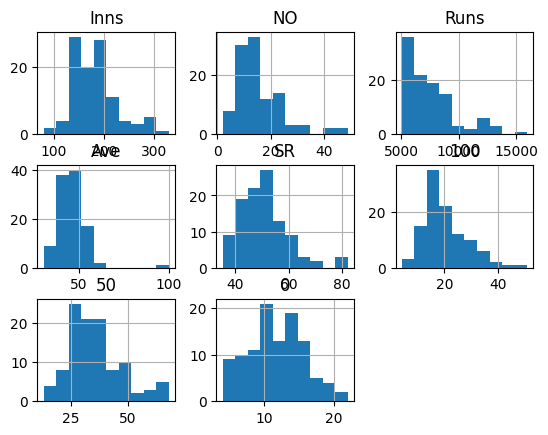

In [38]:
response = df_query_engine.query(
    "Can you plot histogram?",
)

In [ ]:
from llama_index.core.tools import QueryEngineTool


blog_tool = QueryEngineTool.from_defaults(
    query_engine=blog_query_engine,
    description=(
        "Useful for summarization questions related to Prime Minister of India"
    ),
)

df_tool = QueryEngineTool.from_defaults(
    query_engine=df_query_engine,
    description=(
        "Useful for retrieving information about cricket batsment runs and records"
    ),
)

In [ ]:

from llama_index.core.query_engine import RouterQueryEngine
query_engine = RouterQueryEngine(
    selector=PydanticMultiSelector.from_defaults(),
    query_engine_tools=[
        blog_tool,
        df_tool,
    ],
)

In [ ]:
# This query could use either a keyword or vector query engine, so it will combine responses from both
response = query_engine.query(
    "Who is Prime Minister of India in 2024"
)
print(str(response))

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.core.query_engine.router_query_engine:Selecting query engine 0: This choice is directly relevant as it pertains to summarization questions about the Prime Minister of India, which aligns with the query about the Prime Minister in 2024..
Selecting query engine 0: This choice is directly relevant as it pertains to summarization questions about the Prime Minister of India, which aligns with the query about the Prime Minister in 2024..
INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-o

In [ ]:
# This query could use either a keyword or vector query engine, so it will combine responses from both
response = query_engine.query(
    "Who Scored Highest Runs?"
)
print(str(response))

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.core.query_engine.router_query_engine:Selecting query engine 1: This choice directly relates to retrieving information about cricket batsmen runs and records, which is relevant to the question about who scored the highest runs..
Selecting query engine 1: This choice directly relates to retrieving information about cricket batsmen runs and records, which is relevant to the question about who scored the highest runs..
INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.a

In [ ]:
# This query could use either a keyword or vector query engine, so it will combine responses from both
response = query_engine.query(
    "Who Played the highest matches and how many?"
)
print(str(response))

INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
INFO:llama_index.core.query_engine.router_query_engine:Selecting query engine 1: This choice is relevant as it pertains to retrieving information about cricket records, which is likely to include data on matches played by players..
Selecting query engine 1: This choice is relevant as it pertains to retrieving information about cricket records, which is likely to include data on matches played by players..
INFO:httpx:HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments/gpt-4-turbo/chat/completions?api-version=2024-02-01 "HTTP/1.1 200 OK"
HTTP Request: POST https://genai-azure-openai-eq-swe.openai.azure.com//openai/deployments